<a href="https://colab.research.google.com/github/Aishani17/intel-Project-1/blob/main/A1StudentModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Mount Google Drive and unzip CelebA dataset
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_path ="/content/drive/MyDrive/archive (14).zip"
extract_path = "/content/celeba_dataset"  # Destination folder

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction completed!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Extraction completed!


In [ ]:
pip install tensorflow

In [ ]:
# Step 2: Load the Trained Teacher Model
import tensorflow as tf
from tensorflow.keras.models import load_model

# Custom SSIM-based loss and metric (used in the teacher model)
def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_val = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 0.5 * mse + 0.5 * (1 - ssim_val)

# Load the teacher model
teacher_model = load_model(
    '/content/drive/MyDrive/TeacherModel2/teacher_unet.h5',
    custom_objects={'combined_loss': combined_loss, 'ssim_metric': ssim_metric}
)

print("✅ Teacher model loaded successfully!")

✅ Teacher model loaded successfully!


In [ ]:
!pip install opencv-python

In [ ]:
import shutil

# ⚠️ WARNING: This deletes all existing blurred images
if os.path.exists(blurry_folder):
    shutil.rmtree(blurry_folder)

os.makedirs(blurry_folder, exist_ok=True)


NameError: name 'blurry_folder' is not defined

In [ ]:
import cv2
import numpy as np
import random
from tqdm import tqdm

# Define folders again
sharp_folder = os.path.join(extract_path, "img_align_celeba", "img_align_celeba")
blurry_folder = os.path.join(extract_path, "blurry")

# Make blurry folder if not exists
os.makedirs(blurry_folder, exist_ok=True)

# Apply Gaussian or Motion Blur randomly
def apply_motion_blur(image, kernel_size=9):
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel /= kernel_size
    return cv2.filter2D(image, -1, kernel)

def apply_random_blur(image):
    if random.choice(['gaussian', 'motion']) == 'gaussian':
        return cv2.GaussianBlur(image, (9, 9), sigmaX=random.uniform(0.5, 1.5))
    else:
        return apply_motion_blur(image)

# Generate blurred images
def create_blurry_images(src_folder, dest_folder, limit=18000, img_size=(128, 128)):
    count = 0
    files = [f for f in os.listdir(src_folder) if f.endswith('.jpg')]
    random.shuffle(files)

    for filename in tqdm(files, desc="Generating blurry images"):
        img_path = os.path.join(src_folder, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, img_size)
        blurred = apply_random_blur(img)
        cv2.imwrite(os.path.join(dest_folder, filename), blurred)
        count += 1
        if count >= limit:
            break

# Run it
create_blurry_images(sharp_folder, blurry_folder)
print("✅ Blurry images created.")

Generating blurry images:   9%|▉         | 17999/202599 [00:28<04:53, 628.26it/s] 

✅ Blurry images created.


In [ ]:
from sklearn.model_selection import train_test_split
import os

# Step 1: Set paths
sharp_folder = os.path.join(extract_path, "img_align_celeba", "img_align_celeba")
blurry_folder = os.path.join(extract_path, "blurry")

# Step 2: ONLY use the blurred images (you created 8000)
blurred_files = sorted([f for f in os.listdir(blurry_folder) if f.endswith('.jpg')])

# 💡 Optional sanity check
print("Found blurred images:", len(blurred_files))  # Should print 8000

# Step 3: Now split ONLY those
train_files, val_files = train_test_split(blurred_files, test_size=0.2, random_state=42)

print(f"✅ Train: {len(train_files)} | Val: {len(val_files)}")


Found blurred images: 18000
✅ Train: 14400 | Val: 3600


In [ ]:
# ############################################################Step 3: Prepare Data for the Student Model

# 3.1: Load Common File Pairs & Split into Train/Val
from sklearn.model_selection import train_test_split
import os

# Define folders
sharp_folder = os.path.join(extract_path, "img_align_celeba", "img_align_celeba")
blurry_folder = os.path.join(extract_path, "blurry")

# Get common image pairs
blurred_files = sorted(list(set(os.listdir(blurry_folder)).intersection(set(os.listdir(sharp_folder)))))
train_files, val_files = train_test_split(blurred_files, test_size=0.2, random_state=42)

print(f"✅ Train: {len(train_files)} images | Val: {len(val_files)} images")

NameError: name 'blurred_files' is not defined

In [ ]:
# 3.2: Create Data Generator for KD (Blurry → [GT, Teacher Output])
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

class KDImagePairGenerator(Sequence):
    def __init__(self, blurry_dir, sharp_dir, filenames, teacher_model, batch_size=16, img_size=(128, 128), shuffle=True):
        self.blurry_dir = blurry_dir
        self.sharp_dir = sharp_dir
        self.filenames = filenames
        self.teacher_model = teacher_model
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.filenames) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.filenames)

    def __getitem__(self, idx):
        batch_files = self.filenames[idx * self.batch_size : (idx + 1) * self.batch_size]
        x_blur, y_true, y_teacher = [], [], []

        for f in batch_files:
            try:
                blur_path = os.path.join(self.blurry_dir, f)
                sharp_path = os.path.join(self.sharp_dir, f)

                blur_img = img_to_array(load_img(blur_path, target_size=self.img_size)) / 255.0
                sharp_img = img_to_array(load_img(sharp_path, target_size=self.img_size)) / 255.0

                x_blur.append(blur_img)
                y_true.append(sharp_img)
            except Exception as e:
                print(f"Error loading {f}: {e}")
                continue

        x_blur = np.array(x_blur, dtype=np.float32)
        y_true = np.array(y_true, dtype=np.float32)
        y_teacher = self.teacher_model.predict(x_blur, verbose=0)

        # ✅ Concatenate along the channel axis
        combined_target = np.concatenate([y_true, y_teacher], axis=-1)
        return x_blur, tf.convert_to_tensor(combined_target, dtype=tf.float32)



In [ ]:
# 3.3: Initialize Generators
# Create student training and validation generators
train_kd_gen = KDImagePairGenerator(blurry_folder, sharp_folder, train_files, teacher_model, batch_size=32)
val_kd_gen = KDImagePairGenerator(blurry_folder, sharp_folder, val_files, teacher_model, batch_size=32)

print("✅ KD generators ready.")

✅ KD generators ready.


In [ ]:
from tensorflow.keras import layers, Model

def build_student_model(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    # Encoder 1
    c1 = layers.SeparableConv2D(16, 3, padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.LeakyReLU(0.1)(c1)
    c1 = layers.SeparableConv2D(16, 3, padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.LeakyReLU(0.1)(c1)
    p1 = layers.MaxPooling2D()(c1)

    # Encoder 2
    c2 = layers.SeparableConv2D(32, 3, padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.LeakyReLU(0.1)(c2)
    c2 = layers.SeparableConv2D(32, 3, padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.LeakyReLU(0.1)(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck with Dilated Conv
    b = layers.SeparableConv2D(64, 3, padding='same', dilation_rate=2)(p2)
    b = layers.BatchNormalization()(b)
    b = layers.LeakyReLU(0.1)(b)
    b = layers.Dropout(0.1)(b)

    # Decoder 1
    u2 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(b)
    u2 = layers.Add()([u2, c2])  # Add instead of concat
    c3 = layers.SeparableConv2D(32, 3, padding='same')(u2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.LeakyReLU(0.1)(c3)

    # Decoder 2
    u1 = layers.Conv2DTranspose(16, 2, strides=2, padding='same')(c3)
    u1 = layers.Add()([u1, c1])  # Add instead of concat
    c4 = layers.SeparableConv2D(16, 3, padding='same')(u1)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.LeakyReLU(0.1)(c4)

    # Final quality boost
    c4 = layers.Conv2D(16, 3, padding='same', activation='relu')(c4)

    outputs = layers.Conv2D(3, 1, activation='sigmoid')(c4)

    return Model(inputs, outputs, name="LightStudentUNet_v2")


In [ ]:
student_model = build_student_model()
student_model.summary()

Model: "LightStudentUNet_v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 128, 128,  │         91 │ input_layer[0][0] │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 128, 128,  │        416 │ leaky_re_lu[0][0] │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 64, 64,    │        688 │ max_pooling2d[0]… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, 64, 64,    │      1,344 │ leaky_re_lu_2[0]… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ leaky_re_lu_3[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_4  │ (None, 32, 32,    │      2,400 │ max_pooling2d_1[… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ separable_conv2d

 Total params: 20,190 (78.87 KB)

 Trainable params: 19,774 (77.24 KB)

 Non-trainable params: 416 (1.62 KB)

In [ ]:
# Step 5: Define the Knowledge Distillation (KD) Loss & Compile the Student Model

# 5.1: Define Custom KD Loss in TensorFlow
import tensorflow as tf
from tensorflow.keras.losses import Loss

class KDLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.7, beta=0.3, name="kd_loss"):
        super().__init__(name=name)
        self.alpha = alpha
        self.beta = beta

    def call(self, y_true_combined, y_pred):
        y_true_gt = y_true_combined[..., :3]
        y_teacher = y_true_combined[..., 3:]

        mse_teacher = tf.reduce_mean(tf.square(y_pred - y_teacher))
        mse_gt = tf.reduce_mean(tf.square(y_pred - y_true_gt))
        ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_pred, y_true_gt, max_val=1.0))

        return self.alpha * mse_teacher + self.beta * mse_gt +  0.1 * ssim_loss

       # return self.alpha * mse_teacher + self.beta * mse_gt


In [ ]:
# 5.2: Compile the Student Model
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

def ssim_metric(y_true_combined, y_pred):
    y_true_gt = y_true_combined[..., :3]
    return tf.reduce_mean(tf.image.ssim(y_true_gt, y_pred, max_val=1.0))

def mae_metric(y_true_combined, y_pred):
    y_true_gt = y_true_combined[..., :3]
    return tf.reduce_mean(tf.abs(y_true_gt - y_pred))

ssim_metric.__name__ = "ssim"
mae_metric.__name__ = "mae"

student_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=KDLoss(alpha=0.7, beta=0.3),
    metrics=[mae_metric, ssim_metric]
)

print("✅ Student model compiled with KD loss.")

✅ Student model compiled with KD loss.


In [ ]:
################# 5.2: Compile the Student Model
from tensorflow.keras.optimizers import Adam

student_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=KDLoss(alpha=0.7, beta=0.3)
)

print("✅ Student model compiled with KD loss.")

✅ Student model compiled with KD loss.


In [ ]:
import os

# Define the full path
save_dir = "/content/drive/MyDrive/StudentModel3"

# Create the folder if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Define the final path to save the model
model_path = os.path.join(save_dir, "student_model_kd3.h5")


In [ ]:
# Step 6: Train the Student Model Using KD

# 6.1: Set Up Callbacks
from tensorflow.keras import callbacks

# Stop training if no improvement
early_stop = callbacks.EarlyStopping(
    monitor='val_ssim',
    mode='max',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    "/content/StudentModel3/student_model_kd3.h5",
    monitor='val_ssim',
    mode='max',
    save_best_only=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_ssim',
    mode='max',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)


In [ ]:
history = student_model.fit(
    train_kd_gen,
    validation_data=val_kd_gen,
    epochs=50,
    steps_per_epoch=len(train_kd_gen),
    validation_steps=len(val_kd_gen),
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0626 - mae: 0.1073 - ssim: 0.6136
Epoch 1: val_ssim improved from -inf to 0.73098, saving model to /content/StudentModel3/student_model_kd3.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 125s 241ms/step - loss: 0.0626 - mae: 0.1072 - ssim: 0.6138 - val_loss: 0.0347 - val_mae: 0.0706 - val_ssim: 0.7310 - learning_rate: 0.0010
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0234 - mae: 0.0441 - ssim: 0.7991
Epoch 2: val_ssim improved from 0.73098 to 0.78403, saving model to /content/StudentModel3/student_model_kd3.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 128s 231ms/step - loss: 0.0234 - mae: 0.0441 - ssim: 0.7992 - val_loss: 0.0247 - val_mae: 0.0426 - val_ssim: 0.7840 - learning_rate: 0.0010
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0215 - mae: 0.0413 - ssim: 0.8129
Epoch 3: val_ssim improved from 0.78403 to 0.81420, saving model to /content/StudentModel3/student_model_kd3.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 103s 230ms/step - loss: 0.0215 - mae: 0.0413 - ssim: 0.8129 - val_loss: 0.0207 - val_mae: 0.0346 - val_ssim: 0.8142 - learning_rate: 0.0010
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0196 - mae: 0.0386 - ssim: 0.8282
Epoch 4: val_ssim improved from 0.81420 to 0.83786, saving model to /content/StudentModel3/student_model_kd3.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 105s 234ms/step - loss: 0.0196 - mae: 0.0386 - ssim: 0.8282 - val_loss: 0.0180 - val_mae: 0.0330 - val_ssim: 0.8379 - learning_rate: 0.0010
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0181 - mae: 0.0373 - ssim: 0.8407
Epoch 5: val_ssim improved from 0.83786 to 0.85061, saving model to /content/StudentModel3/student_model_kd3.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 105s 234ms/step - loss: 0.0181 - mae: 0.0373 - ssim: 0.8407 - val_loss: 0.0166 - val_mae: 0.0323 - val_ssim: 0.8506 - learning_rate: 0.0010
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0171 - mae: 0.0355 - ssim: 0.8484
Epoch 6: val_ssim improved from 0.85061 to 0.85760, saving model to /content/StudentModel3/student_model_kd3.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 103s 229ms/step - loss: 0.0171 - mae: 0.0355 - ssim: 0.8484 - val_loss: 0.0157 - val_mae: 0.0324 - val_ssim: 0.8576 - learning_rate: 0.0010
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0165 - mae: 0.0343 - ssim: 0.8529
Epoch 7: val_ssim improved from 0.85760 to 0.86311, saving model to /content/StudentModel3/student_model_kd3.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 103s 230ms/step - loss: 0.0165 - mae: 0.0343 - ssim: 0.8529 - val_loss: 0.0151 - val_mae: 0.0300 - val_ssim: 0.8631 - learning_rate: 0.0010
Epoch 8/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0159 - mae: 0.0341 - ssim: 0.8581
Epoch 8: val_ssim improved from 0.86311 to 0.86364, saving model to /content/StudentModel3/student_model_kd3.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 142s 230ms/step - loss: 0.0159 - mae: 0.0341 - ssim: 0.8581 - val_loss: 0.0152 - val_mae: 0.0348 - val_ssim: 0.8636 - learning_rate: 0.0010
Epoch 9/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0156 - mae: 0.0330 - ssim: 0.8605
Epoch 9: val_ssim did not improve from 0.86364
450/450 ━━━━━━━━━━━━━━━━━━━━ 101s 225ms/step - loss: 0.0156 - mae: 0.0330 - ssim: 0.8605 - val_loss: 0.0153 - val_mae: 0.0301 - val_ssim: 0.8597 - learning_rate: 0.0010
Epoch 10/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0153 - mae: 0.0322 - ssim: 0.8626
Epoch 10: val_ssim improved from 0.86364 to 0.86976, saving model to /content/StudentModel3/student_model_kd3.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 163s 273ms/step - loss: 0.0153 - mae: 0.0322 - ssim: 0.8626 - val_loss: 0.0142 - val_mae: 0.0281 - val_ssim: 0.8698 - learning_rate: 0.0010
Epoch 11/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0150 - mae: 0.0321 - ssim: 0.8653
Epoch 11: val_ssim improved from 0.86976 to 0.87185, saving model to /content/StudentModel3/student_model_kd3.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 102s 226ms/step - loss: 0.0150 - mae: 0.0321 - ssim: 0.8653 - val_loss: 0.0140 - val_mae: 0.0295 - val_ssim: 0.8718 - learning_rate: 0.0010
Epoch 12/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0147 - mae: 0.0315 - ssim: 0.8676
Epoch 12: val_ssim did not improve from 0.87185
450/450 ━━━━━━━━━━━━━━━━━━━━ 101s 225ms/step - loss: 0.0147 - mae: 0.0315 - ssim: 0.8676 - val_loss: 0.0142 - val_mae: 0.0303 - val_ssim: 0.8697 - learning_rate: 0.0010
Epoch 13/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0145 - mae: 0.0314 - ssim: 0.8689
Epoch 13: val_ssim improved from 0.87185 to 0.87422, saving model to /content/StudentModel3/student_model_kd3.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 143s 226ms/step - loss: 0.0145 - mae: 0.0314 - ssim: 0.8689 - val_loss: 0.0137 - val_mae: 0.0284 - val_ssim: 0.8742 - learning_rate: 0.0010
Epoch 14/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0142 - mae: 0.0302 - ssim: 0.8715
Epoch 14: val_ssim improved from 0.87422 to 0.87828, saving model to /content/StudentModel3/student_model_kd3.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 104s 231ms/step - loss: 0.0142 - mae: 0.0302 - ssim: 0.8715 - val_loss: 0.0132 - val_mae: 0.0271 - val_ssim: 0.8783 - learning_rate: 0.0010
Epoch 15/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0140 - mae: 0.0303 - ssim: 0.8734
Epoch 15: val_ssim improved from 0.87828 to 0.87885, saving model to /content/StudentModel3/student_model_kd3.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 141s 229ms/step - loss: 0.0140 - mae: 0.0303 - ssim: 0.8734 - val_loss: 0.0131 - val_mae: 0.0267 - val_ssim: 0.8788 - learning_rate: 0.0010
Epoch 16/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0137 - mae: 0.0296 - ssim: 0.8750
Epoch 16: val_ssim did not improve from 0.87885
450/450 ━━━━━━━━━━━━━━━━━━━━ 101s 224ms/step - loss: 0.0137 - mae: 0.0296 - ssim: 0.8750 - val_loss: 0.0140 - val_mae: 0.0267 - val_ssim: 0.8707 - learning_rate: 0.0010
Epoch 17/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0137 - mae: 0.0297 - ssim: 0.8757
Epoch 17: val_ssim did not improve from 0.87885
450/450 ━━━━━━━━━━━━━━━━━━━━ 143s 227ms/step - loss: 0.0137 - mae: 0.0297 - ssim: 0.8757 - val_loss: 0.0136 - val_mae: 0.0329 - val_ssim: 0.8773 - learning_rate: 0.0010
Epoch 18/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0136 - mae: 0.0297 - ssim: 0.8763
Epoch 18: val_ssim improved from 0.87885 to 0.88183, saving model to /content/StudentModel3/student_

450/450 ━━━━━━━━━━━━━━━━━━━━ 103s 229ms/step - loss: 0.0136 - mae: 0.0297 - ssim: 0.8763 - val_loss: 0.0128 - val_mae: 0.0260 - val_ssim: 0.8818 - learning_rate: 0.0010
Epoch 19/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0134 - mae: 0.0295 - ssim: 0.8779
Epoch 19: val_ssim improved from 0.88183 to 0.88285, saving model to /content/StudentModel3/student_model_kd3.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 105s 234ms/step - loss: 0.0134 - mae: 0.0295 - ssim: 0.8779 - val_loss: 0.0127 - val_mae: 0.0261 - val_ssim: 0.8828 - learning_rate: 0.0010
Epoch 20/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0134 - mae: 0.0294 - ssim: 0.8778
Epoch 20: val_ssim did not improve from 0.88285
450/450 ━━━━━━━━━━━━━━━━━━━━ 101s 223ms/step - loss: 0.0134 - mae: 0.0294 - ssim: 0.8778 - val_loss: 0.0129 - val_mae: 0.0264 - val_ssim: 0.8819 - learning_rate: 0.0010
Epoch 21/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0133 - mae: 0.0292 - ssim: 0.8786
Epoch 21: val_ssim improved from 0.88285 to 0.88345, saving model to /content/StudentModel3/student_model_kd3.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 102s 227ms/step - loss: 0.0133 - mae: 0.0292 - ssim: 0.8786 - val_loss: 0.0127 - val_mae: 0.0283 - val_ssim: 0.8834 - learning_rate: 0.0010
Epoch 22/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0131 - mae: 0.0287 - ssim: 0.8806
Epoch 22: val_ssim did not improve from 0.88345
450/450 ━━━━━━━━━━━━━━━━━━━━ 103s 229ms/step - loss: 0.0131 - mae: 0.0287 - ssim: 0.8806 - val_loss: 0.0134 - val_mae: 0.0289 - val_ssim: 0.8767 - learning_rate: 0.0010
Epoch 23/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0132 - mae: 0.0292 - ssim: 0.8801
Epoch 23: val_ssim did not improve from 0.88345
450/450 ━━━━━━━━━━━━━━━━━━━━ 105s 234ms/step - loss: 0.0132 - mae: 0.0292 - ssim: 0.8801 - val_loss: 0.0131 - val_mae: 0.0277 - val_ssim: 0.8788 - learning_rate: 0.0010
Epoch 24/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0130 - mae: 0.0287 - ssim: 0.8818
Epoch 24: val_ssim improved from 0.88345 to 0.88488, saving model to /content/StudentModel3/student_

450/450 ━━━━━━━━━━━━━━━━━━━━ 122s 271ms/step - loss: 0.0130 - mae: 0.0287 - ssim: 0.8818 - val_loss: 0.0125 - val_mae: 0.0288 - val_ssim: 0.8849 - learning_rate: 0.0010
Epoch 25/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0128 - mae: 0.0281 - ssim: 0.8833
Epoch 25: val_ssim improved from 0.88488 to 0.88513, saving model to /content/StudentModel3/student_model_kd3.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 104s 231ms/step - loss: 0.0128 - mae: 0.0281 - ssim: 0.8833 - val_loss: 0.0124 - val_mae: 0.0256 - val_ssim: 0.8851 - learning_rate: 0.0010
Epoch 26/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0128 - mae: 0.0282 - ssim: 0.8827
Epoch 26: val_ssim did not improve from 0.88513
450/450 ━━━━━━━━━━━━━━━━━━━━ 142s 232ms/step - loss: 0.0128 - mae: 0.0282 - ssim: 0.8828 - val_loss: 0.0124 - val_mae: 0.0254 - val_ssim: 0.8851 - learning_rate: 0.0010
Epoch 27/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0128 - mae: 0.0281 - ssim: 0.8832
Epoch 27: val_ssim did not improve from 0.88513
450/450 ━━━━━━━━━━━━━━━━━━━━ 141s 230ms/step - loss: 0.0128 - mae: 0.0281 - ssim: 0.8832 - val_loss: 0.0125 - val_mae: 0.0258 - val_ssim: 0.8843 - learning_rate: 0.0010
Epoch 28/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0127 - mae: 0.0281 - ssim: 0.8842
Epoch 28: val_ssim did not improve from 0.88513
450/450 ━━━━━━━━━━━━━━━━━━━━ 139s 222ms/step - loss:

450/450 ━━━━━━━━━━━━━━━━━━━━ 104s 231ms/step - loss: 0.0126 - mae: 0.0279 - ssim: 0.8845 - val_loss: 0.0124 - val_mae: 0.0262 - val_ssim: 0.8864 - learning_rate: 0.0010
Epoch 30/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0125 - mae: 0.0276 - ssim: 0.8855
Epoch 30: val_ssim improved from 0.88645 to 0.88750, saving model to /content/StudentModel3/student_model_kd3.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 141s 230ms/step - loss: 0.0125 - mae: 0.0276 - ssim: 0.8855 - val_loss: 0.0122 - val_mae: 0.0279 - val_ssim: 0.8875 - learning_rate: 0.0010
Epoch 31/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0124 - mae: 0.0277 - ssim: 0.8861
Epoch 31: val_ssim did not improve from 0.88750
450/450 ━━━━━━━━━━━━━━━━━━━━ 106s 237ms/step - loss: 0.0124 - mae: 0.0277 - ssim: 0.8861 - val_loss: 0.0122 - val_mae: 0.0268 - val_ssim: 0.8868 - learning_rate: 0.0010
Epoch 32/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0125 - mae: 0.0277 - ssim: 0.8855
Epoch 32: val_ssim did not improve from 0.88750
450/450 ━━━━━━━━━━━━━━━━━━━━ 158s 272ms/step - loss: 0.0125 - mae: 0.0277 - ssim: 0.8855 - val_loss: 0.0127 - val_mae: 0.0269 - val_ssim: 0.8839 - learning_rate: 0.0010
Epoch 33/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0124 - mae: 0.0278 - ssim: 0.8862
Epoch 33: val_ssim improved from 0.88750 to 0.88842, saving model to /content/StudentModel3/student_

450/450 ━━━━━━━━━━━━━━━━━━━━ 100s 222ms/step - loss: 0.0124 - mae: 0.0278 - ssim: 0.8862 - val_loss: 0.0122 - val_mae: 0.0295 - val_ssim: 0.8884 - learning_rate: 0.0010
Epoch 34/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0124 - mae: 0.0274 - ssim: 0.8862
Epoch 34: val_ssim did not improve from 0.88842
450/450 ━━━━━━━━━━━━━━━━━━━━ 105s 234ms/step - loss: 0.0124 - mae: 0.0274 - ssim: 0.8862 - val_loss: 0.0126 - val_mae: 0.0256 - val_ssim: 0.8840 - learning_rate: 0.0010
Epoch 35/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.0124 - mae: 0.0278 - ssim: 0.8868
Epoch 35: val_ssim did not improve from 0.88842
450/450 ━━━━━━━━━━━━━━━━━━━━ 144s 237ms/step - loss: 0.0124 - mae: 0.0278 - ssim: 0.8868 - val_loss: 0.0128 - val_mae: 0.0251 - val_ssim: 0.8804 - learning_rate: 0.0010
Epoch 36/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0122 - mae: 0.0271 - ssim: 0.8875
Epoch 36: val_ssim improved from 0.88842 to 0.89058, saving model to /content/StudentModel3/student_

450/450 ━━━━━━━━━━━━━━━━━━━━ 135s 221ms/step - loss: 0.0122 - mae: 0.0271 - ssim: 0.8875 - val_loss: 0.0118 - val_mae: 0.0257 - val_ssim: 0.8906 - learning_rate: 0.0010
Epoch 37/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0122 - mae: 0.0272 - ssim: 0.8878
Epoch 37: val_ssim did not improve from 0.89058
450/450 ━━━━━━━━━━━━━━━━━━━━ 142s 222ms/step - loss: 0.0122 - mae: 0.0272 - ssim: 0.8878 - val_loss: 0.0123 - val_mae: 0.0258 - val_ssim: 0.8858 - learning_rate: 0.0010
Epoch 38/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0121 - mae: 0.0272 - ssim: 0.8884
Epoch 38: val_ssim did not improve from 0.89058
450/450 ━━━━━━━━━━━━━━━━━━━━ 144s 228ms/step - loss: 0.0121 - mae: 0.0271 - ssim: 0.8884 - val_loss: 0.0124 - val_mae: 0.0281 - val_ssim: 0.8851 - learning_rate: 0.0010
Epoch 39/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0123 - mae: 0.0274 - ssim: 0.8874
Epoch 39: val_ssim did not improve from 0.89058
450/450 ━━━━━━━━━━━━━━━━━━━━ 142s 229ms/step - loss:

450/450 ━━━━━━━━━━━━━━━━━━━━ 140s 225ms/step - loss: 0.0120 - mae: 0.0268 - ssim: 0.8900 - val_loss: 0.0114 - val_mae: 0.0256 - val_ssim: 0.8937 - learning_rate: 5.0000e-04
Epoch 44/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0119 - mae: 0.0268 - ssim: 0.8902
Epoch 44: val_ssim did not improve from 0.89370
450/450 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - loss: 0.0119 - mae: 0.0268 - ssim: 0.8902 - val_loss: 0.0116 - val_mae: 0.0244 - val_ssim: 0.8921 - learning_rate: 5.0000e-04
Epoch 45/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0120 - mae: 0.0267 - ssim: 0.8897
Epoch 45: val_ssim did not improve from 0.89370
450/450 ━━━━━━━━━━━━━━━━━━━━ 100s 223ms/step - loss: 0.0120 - mae: 0.0267 - ssim: 0.8897 - val_loss: 0.0120 - val_mae: 0.0247 - val_ssim: 0.8884 - learning_rate: 5.0000e-04
Epoch 46/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0118 - mae: 0.0264 - ssim: 0.8906
Epoch 46: val_ssim improved from 0.89370 to 0.89433, saving model to /content/StudentMod

450/450 ━━━━━━━━━━━━━━━━━━━━ 145s 230ms/step - loss: 0.0118 - mae: 0.0264 - ssim: 0.8906 - val_loss: 0.0114 - val_mae: 0.0252 - val_ssim: 0.8943 - learning_rate: 5.0000e-04
Epoch 47/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0119 - mae: 0.0266 - ssim: 0.8906
Epoch 47: val_ssim did not improve from 0.89433
450/450 ━━━━━━━━━━━━━━━━━━━━ 141s 228ms/step - loss: 0.0119 - mae: 0.0266 - ssim: 0.8906 - val_loss: 0.0114 - val_mae: 0.0241 - val_ssim: 0.8943 - learning_rate: 5.0000e-04
Epoch 48/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0118 - mae: 0.0263 - ssim: 0.8908
Epoch 48: val_ssim did not improve from 0.89433
450/450 ━━━━━━━━━━━━━━━━━━━━ 100s 223ms/step - loss: 0.0118 - mae: 0.0263 - ssim: 0.8908 - val_loss: 0.0122 - val_mae: 0.0239 - val_ssim: 0.8865 - learning_rate: 5.0000e-04
Epoch 49/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0118 - mae: 0.0264 - ssim: 0.8916
Epoch 49: val_ssim did not improve from 0.89433
450/450 ━━━━━━━━━━━━━━━━━━━━ 101s 224ms/

In [ ]:
from skimage.metrics import structural_similarity as ssim


In [ ]:
student_model.save("/content/drive/MyDrive/StudentModel3/stud_model_kd3.h5")

In [ ]:
def evaluate_model(model, data_gen, num_batches=10):
    total_ssim = 0.0
    total_mae = 0.0
    count = 0

    for batch_index in range(num_batches):
        x_batch, y_combined = data_gen[batch_index]
        y_true_batch = y_combined[..., :3]  # Extract only the ground truth sharp image

        preds = model.predict(x_batch, verbose=0)

        for pred_img, true_img in zip(preds, y_true_batch):
            pred_gray = tf.image.rgb_to_grayscale(pred_img).numpy().squeeze()
            true_gray = tf.image.rgb_to_grayscale(true_img).numpy().squeeze()

            score = ssim(pred_gray, true_gray, data_range=1.0)
            total_ssim += score

            mae = np.mean(np.abs(pred_img - true_img))
            total_mae += mae
            count += 1

    avg_ssim = total_ssim / count
    avg_mae = total_mae / count
    return avg_ssim, avg_mae


In [ ]:
student_ssim, student_mae = evaluate_model(student_model, val_kd_gen)
print(f"📘 Student Model → SSIM: {student_ssim:.4f}, MAE: {student_mae:.4f}")

teacher_ssim, teacher_mae = evaluate_model(teacher_model, val_kd_gen)
print(f"📗 Teacher Model → SSIM: {teacher_ssim:.4f}, MAE: {teacher_mae:.4f}")


📘 Student Model → SSIM: 0.9138, MAE: 0.0251
📗 Teacher Model → SSIM: 0.9301, MAE: 0.0222


In [ ]:
ssim_score, mae_score = evaluate_model(student_model, val_kd_gen, num_batches=10)
print(f"📊 Average SSIM: {ssim_score:.4f}")
print(f"📊 Average MAE: {mae_score:.4f}")


📊 Average SSIM: 0.9138
📊 Average MAE: 0.0251


In [ ]:
# 7.2: Visual Comparison (Blurry | Student | Sharp | Teacher)
import cv2
import matplotlib.pyplot as plt

def visualize_student_vs_teacher(index=0):
    filename = val_files[index]

    # Load blurry and sharp
    blurry_path = os.path.join(blurry_folder, filename)
    sharp_path = os.path.join(sharp_folder, filename)

    blur = cv2.imread(blurry_path)
    sharp = cv2.imread(sharp_path)

    if blur is None or sharp is None:
        print("Error loading images.")
        return

    blur = cv2.resize(blur, (128, 128))
    sharp = cv2.resize(sharp, (128, 128))

    input_img = np.expand_dims(blur.astype("float32") / 255.0, axis=0)

    # Predict
    student_pred = student_model.predict(input_img, verbose=0)[0]
    teacher_pred = teacher_model.predict(input_img, verbose=0)[0]

    student_pred = (student_pred * 255).astype("uint8")
    teacher_pred = (teacher_pred * 255).astype("uint8")

    # Plot
    titles = ["Blurry Input", "Student Output", "Sharp Ground Truth", "Teacher Output"]
    images = [blur, student_pred, sharp, teacher_pred]

    plt.figure(figsize=(12, 3))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

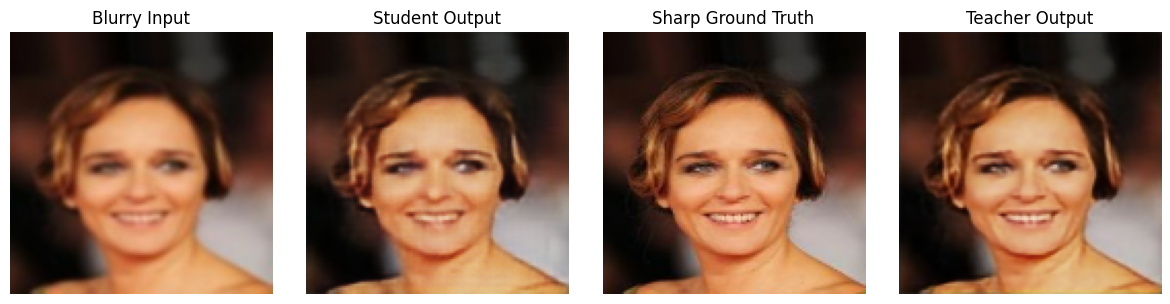

In [ ]:
visualize_student_vs_teacher(index=5)

To resolve the error, you need to modify your data generator (`train_kd_gen` and `val_kd_gen`) to yield the input image and a combined target tensor containing both the ground truth and the teacher's output. This combined target will be passed as `y_true` to the `KDLoss` function.

Here's a conceptual example of how your data generator's `__getitem__` method should be structured:

In [ ]:
# Conceptual Example of Data Generator __getitem__

# Assume you have already loaded and preprocessed blurry_image and sharp_image
# Assume you have the teacher_model available

# Get the teacher's output for the current blurry image
# Ensure blurry_image is in the correct shape and format for the teacher model
# For example, if teacher_model expects a batch:
# blurry_input_batch = np.expand_dims(blurry_image, axis=0)
# teacher_output = teacher_model.predict(blurry_input_batch)[0]

# Combine ground truth and teacher output
# combined_target = tf.concat([sharp_image, teacher_output], axis=-1)

# Yield the input image and the combined target
# return blurry_image, combined_target

print("✅ Data generator modification concept shown.")

✅ Data generator modification concept shown.


Once you have updated your data generators, you can re-run the training cell.